In [18]:
import os
import tensorflow as tf

In [19]:

data_directory = os.getcwd().rsplit("/", 1)[0] + "/data/224x224_currency"
print(data_directory)


/Users/ujjwal/Documents/data/224x224_currency


In [20]:
model_dir = os.getcwd() + "/experiments/smaller_model/4_ConvBlock"
data_dir = os.getcwd().rsplit("/", 1)[0] + "/data/224x224_currency"

In [21]:
from model.utils import Params

In [22]:
tf.random.set_seed(230)
json_path = os.path.join(model_dir, "params.json")
assert os.path.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params

In [23]:
train_data_dir = os.path.join(data_dir, "train_dir")
dev_data_dir = os.path.join(data_dir, "dev_dir")

In [24]:
train_filenames = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith(".jpg")]
eval_filenames = [os.path.join(dev_data_dir, f) for f in os.listdir(dev_data_dir) if f.endswith(".jpg")]

    # Labels will be between 0 and 5 included (6 classes in total)
train_labels = [int(f.split("/")[-1].split("_")[0]) for f in train_filenames]
eval_labels = [int(f.split("/")[-1].split("_")[0]) for f in eval_filenames]

In [25]:
from model.input_fn import input_fn
from sklearn.preprocessing import LabelEncoder

In [26]:
labelencoder = LabelEncoder()
train_labels = labelencoder.fit_transform(train_labels)
eval_labels = labelencoder.fit_transform(eval_labels)

In [27]:
params.train_size = len(train_filenames)
params.eval_size = len(eval_filenames)

train_labels = tf.cast(train_labels, tf.int32)
eval_labels = tf.cast(eval_labels, tf.int32)

In [28]:
train_inputs = input_fn(True, train_filenames, train_labels, params)
eval_inputs = input_fn(False, eval_filenames, eval_labels, params)

In [29]:
train_inputs

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [30]:
train_inputs

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [31]:
import matplotlib.pyplot as plt

(224, 224, 3)
32


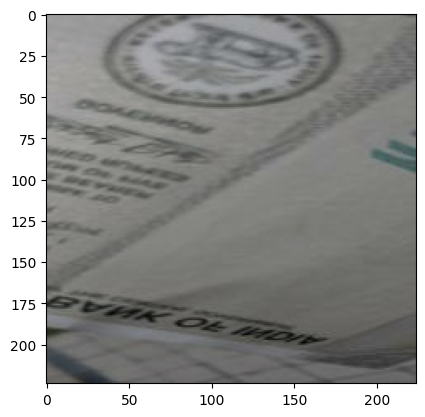

In [32]:
features, labels = next(iter(train_inputs))

print(features[0].shape)
print(len(labels))

plt.imshow(features[0])

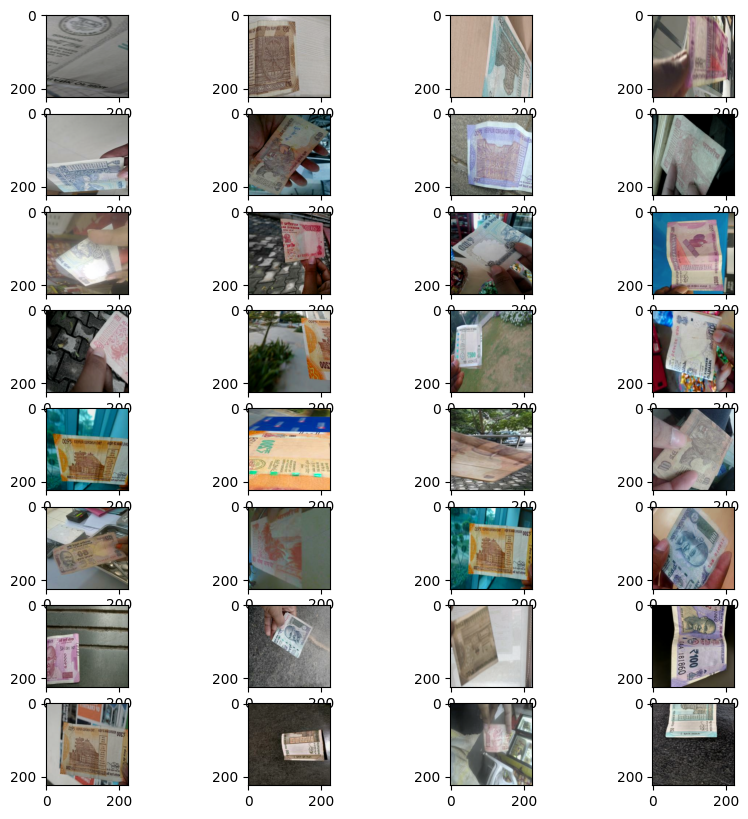

In [33]:
rows=8
cols = 4
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

for i in range(rows):
    for j in range(cols):        
        if img_count < 32:
            axes[i, j].imshow(features[img_count])
            img_count+=1

In [34]:
from tensorflow.keras import datasets, layers, models

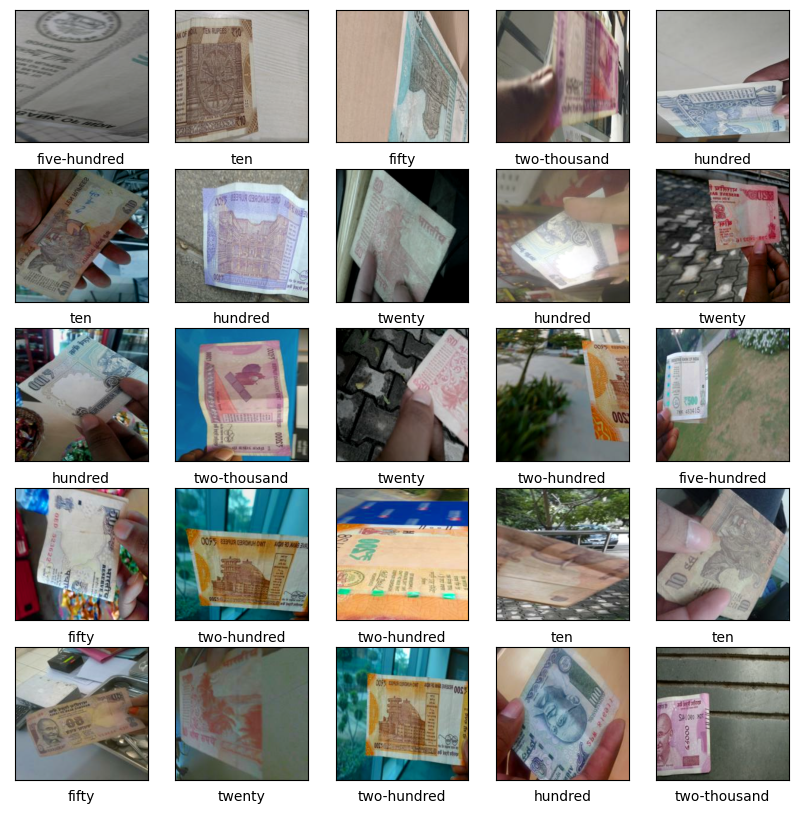

In [35]:
class_names = ['ten', 'twenty', 'fifty', 'hundred', 'two-hundred',
               'five-hundred', 'two-thousand']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(features[i])
    plt.xlabel(class_names[labels[i]])
plt.show()

In [36]:
import tensorflow as tf
import os
import time


class CNN(tf.keras.Model):
    def __init__(self, num_classes, device="cpu:0", checkpoint_directory=None, params=None):

        super(CNN, self).__init__()
        # alexnet implementation
        self.cnn1 = tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, activation="relu")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.maxpool1 = tf.keras.layers.MaxPool2D(pool_size=3, strides=2)

        self.cnn2 = tf.keras.layers.Conv2D(filters=256, kernel_size=5, strides=1, activation="relu")
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.maxpool2 = tf.keras.layers.MaxPool2D(pool_size=3, strides=2)

        self.cnn3 = tf.keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, activation="relu")
        self.bn3 = tf.keras.layers.BatchNormalization()

        self.cnn4 = tf.keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, activation="relu")
        self.bn4 = tf.keras.layers.BatchNormalization()

        self.cnn5 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, activation="relu")
        self.bn5 = tf.keras.layers.BatchNormalization()

        self.maxpool3 = tf.keras.layers.MaxPool2D(pool_size=3, strides=2)
        self.flatten1 = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(4096, activation="relu")
        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.dense2 = tf.keras.layers.Dense(4096, activation="relu")
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.classifier = tf.keras.layers.Dense(num_classes)

        self.device = device
        self.checkpoint = tf.train.Checkpoint(model=self)
        self.checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")
        self.params = params

    def predict(self, inputs, training):
        # alexnet implementation
        x = self.cnn1(inputs)
        x = self.bn1(x, training=training)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.bn2(x, training=training)
        x = self.maxpool2(x)
        x = self.cnn3(x)
        x = self.bn3(x, training=training)
        x = self.cnn4(x)
        x = self.bn4(x, training=training)
        x = self.cnn5(x)
        x = self.bn5(x, training=training)
        x = self.maxpool3(x)
        x = self.flatten1(x)
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense2(x)
        x = self.dropout2(x, training=training)
        output = self.classifier(x)

        return output

In [37]:
out_dir = os.getcwd().rsplit("/", 1)[0]
ckpt = os.path.join(out_dir, "experiments/checkpoints")

    # Define optimizer.
optimizer = tf.optimizers.Adam()

    # Instantiate model. This doesn't initialize the variables yet.
model = CNN(num_classes=params.num_labels, checkpoint_directory=ckpt, params=params)
    # compile model. This initializes the variables.
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [38]:
features, labels = next(iter(train_inputs))

In [39]:
features.shape

TensorShape([32, 224, 224, 3])

In [40]:
logits = model.predict(features,training=True)
logits,labels

(<tf.Tensor: shape=(32, 7), dtype=float32, numpy=
 array([[ 0.2700612 , -3.2634292 , -0.5750483 ,  1.0892944 ,  0.9721846 ,
         -0.90796125, -1.7829647 ],
        [ 0.35397813, -0.09905411, -0.260411  ,  0.8509865 , -0.6152377 ,
          0.0518367 , -0.873296  ],
        [-0.5642699 , -0.11990553, -0.4987465 , -0.01002324,  0.8280899 ,
         -1.3111292 , -2.0208964 ],
        [ 0.5469318 ,  0.40051693, -0.7014569 ,  2.3220146 , -0.20172723,
          0.4830004 , -1.4970117 ],
        [-0.19078523, -0.8345499 , -0.40107018,  1.227282  , -0.76250994,
          0.43147525, -0.4346726 ],
        [ 0.6729531 , -1.4156369 , -0.47149128, -0.24225084,  2.2064543 ,
          0.6004938 ,  0.88895226],
        [-0.26850927, -0.5657813 , -0.1654594 ,  1.6341081 , -0.5534704 ,
         -0.7970491 , -1.0706962 ],
        [-0.41374695, -0.5765252 , -0.077066  ,  0.23082452,  0.18839416,
         -0.26190525, -1.1333287 ],
        [ 0.18381506, -0.524963  , -0.20575859,  0.47902793,  0.062457

In [42]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn(labels,logits)

<tf.Tensor: shape=(), dtype=float32, numpy=2.2759495>

In [44]:
# for step,(x_batch,y_batch) in enumerate(train_inputs):
#     logits = model.predict(x_batch, training = True)
#     loss = loss_fn(y_batch,logits)
#     print(loss)

In [45]:
print("Training loss (for one batch) at step {}: {}".format(11, float(22)))

Training loss (for one batch) at step 11: 22.0
